In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw""
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using VPL

module btree
    import VPL
    # Meristem
    struct Meristem <: VPL.Node end
    # Node
    struct Node <: VPL.Node end
    # Internode
    mutable struct Internode <: VPL.Node
        length::Float64
    end
    # Graph-level variables
    struct treeparams
        growth::Float64
    end
end

Main.btree

In [3]:
function VPL.feed!(turtle::MTurtle, i::btree.Internode)
    HollowCube!(turtle, l = i.length, h = i.length/10, w = i.length/10, move = true)
    return nothing
end
function VPL.feedcolor!(turtle::GLTurtle, i::btree.Internode)
    feedcolor!(turtle, RGB(0,1,0))
    return nothing
end

In [4]:
rule = Rule(btree.Meristem, rhs = mer -> btree.Node() + (RU(-60.0) + btree.Internode(0.1) + RH(90.0) + btree.Meristem(), 
                                                   RU(60.0)  + btree.Internode(0.1) + RH(90.0) + btree.Meristem()))

Rule replacing nodes of type Main.btree.Meristem without context capturing.


In [5]:
axiom = btree.Internode(0.1) + btree.Meristem()

VPL.Core.StaticGraph(Dict{Int64, Any}(2 => VPL.Core.GraphNode{Main.btree.Meristem}(Main.btree.Meristem(), Set{Int64}(), 1, 2), 1 => VPL.Core.GraphNode{Main.btree.Internode}(Main.btree.Internode(0.1), Set([2]), missing, 1)), Dict{DataType, Set{Int64}}(Main.btree.Internode => Set([1]), Main.btree.Meristem => Set([2])), 1, 2)

In [6]:
tree = Graph(axiom, Tuple(rule), btree.treeparams(0.5))

Dynamic graph with 2 nodes of types Main.btree.Internode,Main.btree.Meristem and 1 rewriting rules.
Dynamic graph variables stored in struct of type Main.btree.treeparams


In [7]:
getInternode = Query(btree.Internode)

Query object for nodes of type Main.btree.Internode


In [8]:
function elongate!(tree, query)
    for x in apply(tree, query)
        x.length = x.length*(1.0 + vars(tree).growth)
    end
end

elongate! (generic function with 1 method)

In [9]:
function growth!(tree, query)
    elongate!(tree, query)
    rewrite!(tree)
end

growth! (generic function with 1 method)

In [10]:
function simulate(tree, query, nsteps)
    new_tree = deepcopy(tree)
    for i in 1:nsteps
        growth!(new_tree, query)
    end
    return new_tree
end

simulate (generic function with 1 method)

In [11]:
newtree = simulate(tree, getInternode, 2)

Dynamic graph with 26 nodes of types Main.btree.Node,Main.btree.Internode,Main.btree.Meristem,VPL.Geom.RH{Float64},VPL.Geom.RU{Float64} and 1 rewriting rules.
Dynamic graph variables stored in struct of type Main.btree.treeparams


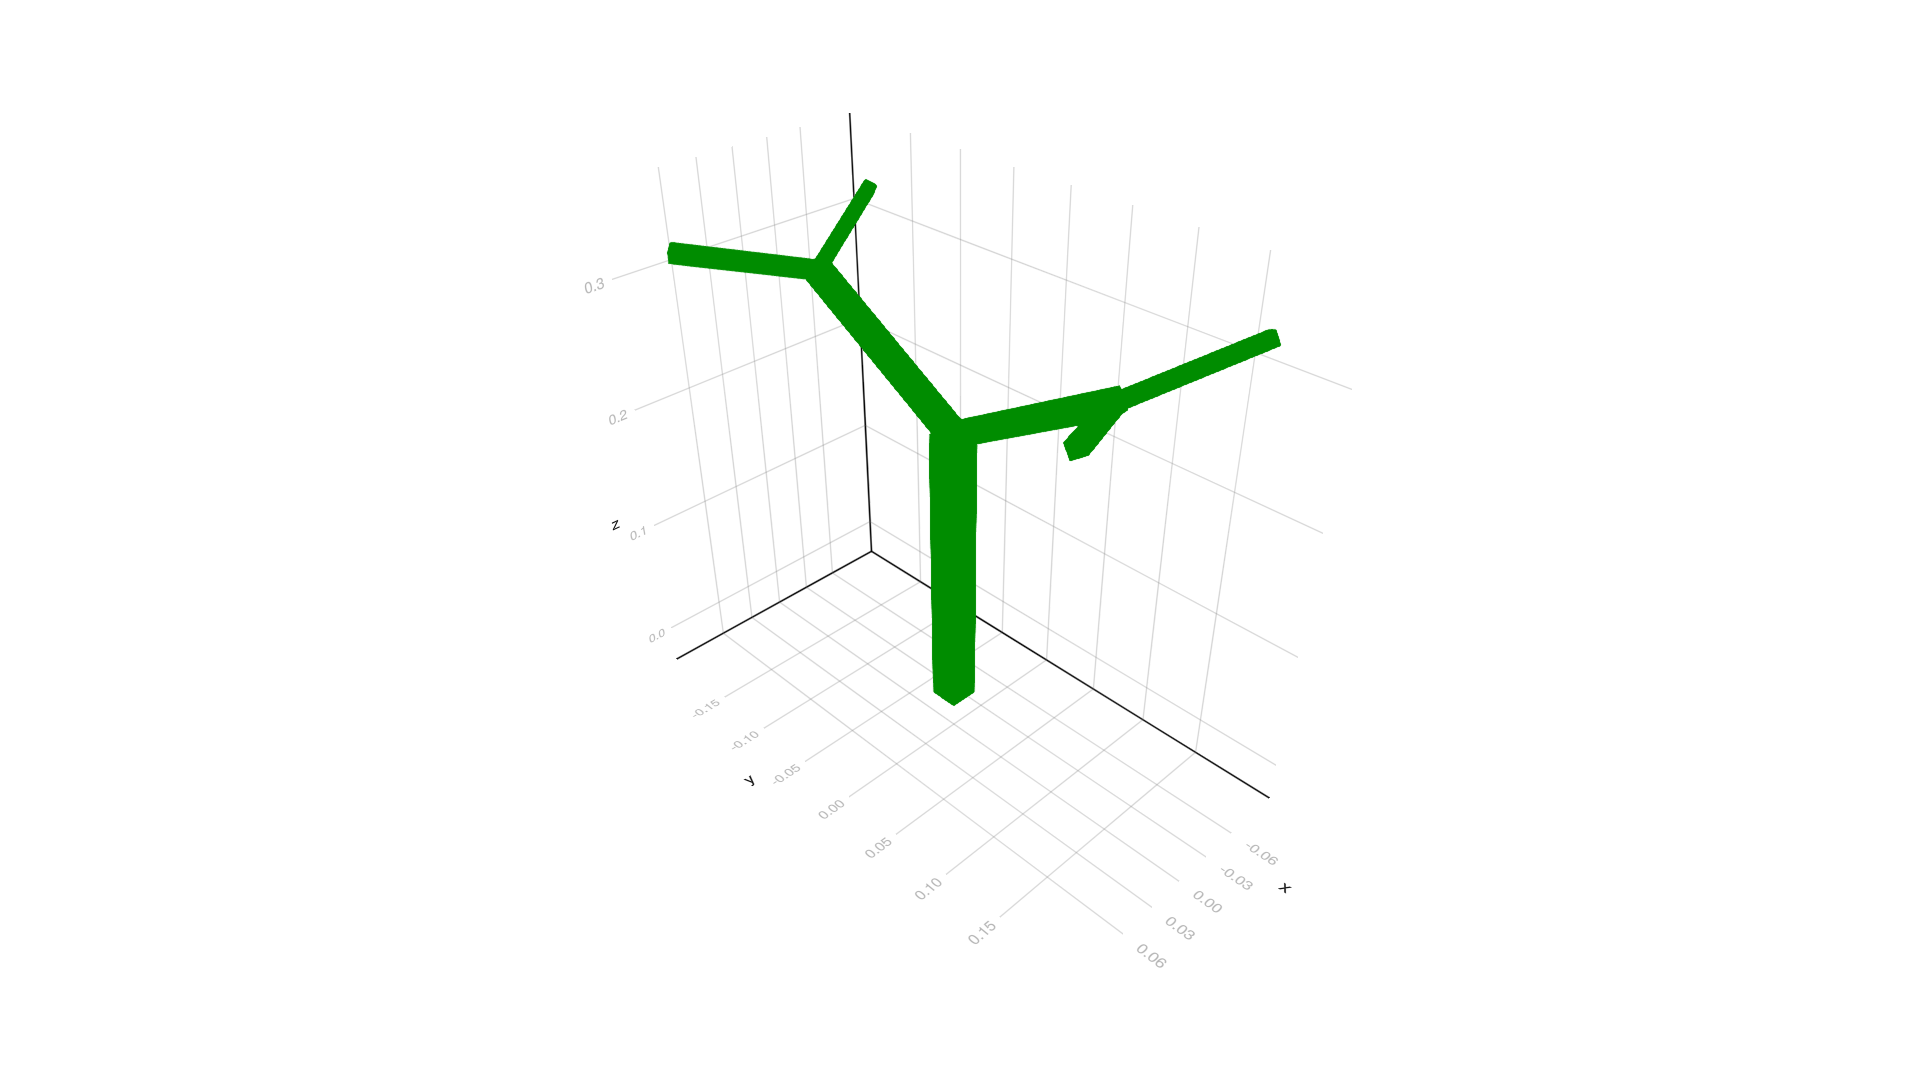

In [12]:
render(newtree)

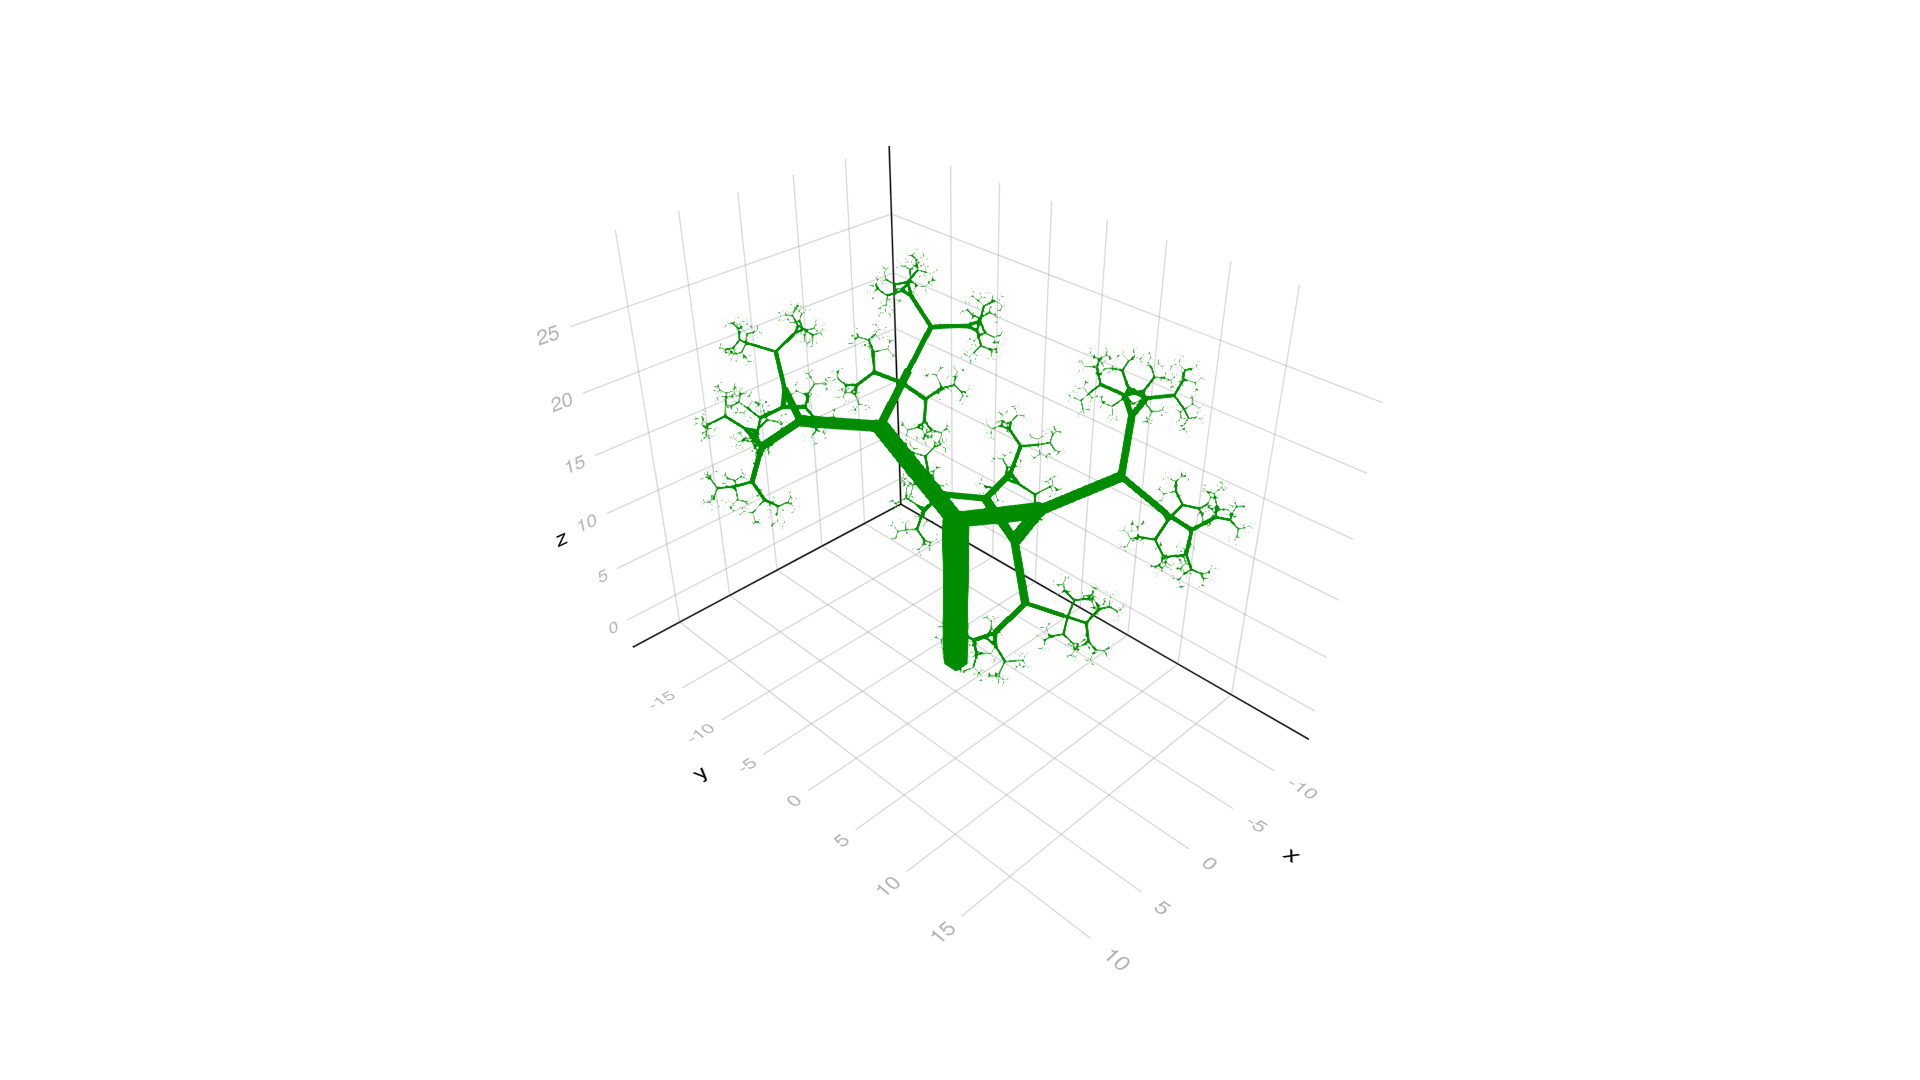

In [13]:
newtree = simulate(newtree, getInternode, 10)
render(newtree)